<a href="https://colab.research.google.com/github/ArthAgrawal/Brain-Tumor-Research-Paper/blob/main/Final_Dataset_Balanced_(Albumentations).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_folder_path = '/content/drive/MyDrive/Brain_Tumor_44'


In [3]:
import os
class_counts = {}
for class_folder in os.listdir(dataset_folder_path):
    class_path = os.path.join(dataset_folder_path, class_folder)

    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_folder] = num_images

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")


Class: Carcinoma T1, Number of images: 65
Class: Oligodendroglioma T1, Number of images: 86
Class: Tuberculoma T1, Number of images: 28
Class: Meduloblastoma T1, Number of images: 23
Class: Papiloma T1, Number of images: 66
Class: Ependimoma T1, Number of images: 45
Class: Neurocitoma T1, Number of images: 130
Class: Granuloma T1, Number of images: 30
Class: Ganglioglioma T1, Number of images: 20
Class: Schwannoma T1, Number of images: 148
Class: _NORMAL T1, Number of images: 251
Class: Glioblastoma T1, Number of images: 55
Class: Meningioma T1, Number of images: 272
Class: Germinoma T1, Number of images: 27
Class: Astrocitoma T1, Number of images: 176


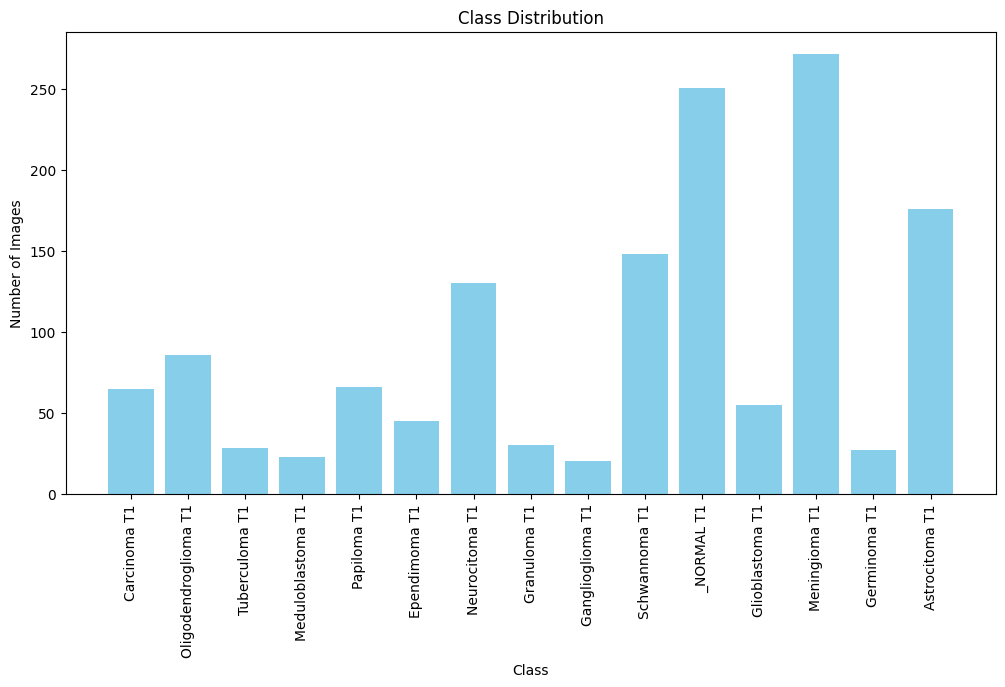

In [4]:
import matplotlib.pyplot as plt

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()


In [6]:
from google.colab import drive
drive.mount('/content/drive')
import albumentations as A
import cv2
import numpy as np
import os
import random

def create_augmentation_pipeline():
  return A.Compose([
      A.CLAHE(clip_limit=(1, 1.5), tile_grid_size=(8, 8), p=0.2),
      A.Defocus(radius=(1, 1.5), p=0.2),  # Reduced radius for minimal blur
      A.Downscale(p=0.2, scale_min=0.9, scale_max=1.0),
      A.GaussianBlur(p=0.2, blur_limit=(1, 3), sigma_limit=(0.1, 0.5)),  # Minimal blur limits
      A.HorizontalFlip(p=0.1),
      A.HueSaturationValue(p=0.2, hue_shift_limit=(-5, 5), sat_shift_limit=(-5, 5), val_shift_limit=(-5, 5)),  # Very minor color changes
      A.RandomGamma(p=0.2, gamma_limit=(1, 1.1)),
      A.Transpose(p=0.1),
      A.ZoomBlur(p=0.1, max_factor=(1.0, 1.02), step_factor=(0.01, 0.01))  # Very minor zoom effect
  ])


def augment_images_for_class(image_paths, output_dir, target_size=400):
    augmentation_pipeline = create_augmentation_pipeline()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    log_file_path = os.path.join(output_dir, "augmentation_log.csv")
    with open(log_file_path, 'w') as log_file:
        log_file.write("Image Filename, Augmentation Applied\n")

        num_original_images = len(image_paths)
        num_needed_augmented_images = target_size - num_original_images
        augmented_images_count = 0

        print(f"Processing class with {num_original_images} original images.")

        # If the number of original images exceeds or meets the target size
        if num_needed_augmented_images <= 0:
            print(f"No augmentation needed. The class already has {num_original_images} images.")
            return

        print(f"Number of augmented images needed: {num_needed_augmented_images}")

        for i, image_path in enumerate(image_paths):
            if augmented_images_count >= num_needed_augmented_images:
                break

            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Image at {image_path} could not be loaded.")
                continue
            base_filename = f"original{i + 1}"
            output_image_path = os.path.join(output_dir, f"{base_filename}.jpeg")
            cv2.imwrite(output_image_path, image)

            log_file.write(f"{base_filename}, Original\n")

        while augmented_images_count < num_needed_augmented_images:
            for i, image_path in enumerate(image_paths):
                if augmented_images_count >= num_needed_augmented_images:
                    break

                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Image at {image_path} could not be loaded.")
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (256, 256))  # Resize to a fixed size

                augmented = augmentation_pipeline(image=image)
                augmented_image = augmented['image']
                aug_image_name = f"original{i + 1}-augmented{augmented_images_count + 1}.jpeg"
                output_aug_path = os.path.join(output_dir, aug_image_name)
                cv2.imwrite(output_aug_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

                # Logging only applied augmentations
                log_file.write(f"{aug_image_name}, ")
                applied_augmentations = []
                for transform in augmentation_pipeline.transforms:
                    if random.random() < transform.p:
                        applied_augmentations.append(transform.__class__.__name__)
                log_file.write(", ".join(applied_augmentations) + "\n")

                augmented_images_count += 1

        print(f"Final count of augmented images for class: {augmented_images_count}")

def process_dataset(dataset_path, output_path, target_size=400):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        for class_dir in os.listdir(output_path):
            class_path = os.path.join(output_path, class_dir)
            if os.path.isdir(class_path):
                for f in os.listdir(class_path):
                    os.remove(os.path.join(class_path, f))
                os.rmdir(class_path)

    class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(dataset_path, class_dir)
        image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('.jpeg', '.jpg'))]
        num_images = len(image_paths)
        if num_images > 0:
            output_dir = os.path.join(output_path, f"{class_dir}_augmented")
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            else:
                for f in os.listdir(output_dir):
                    os.remove(os.path.join(output_dir, f))

            augment_images_for_class(image_paths, output_dir, target_size)

            augmented_image_count = len([f for f in os.listdir(output_dir) if f.endswith(('.jpg', '.jpeg'))])
            print(f"Processed class '{class_dir}': {num_images} original images, augmented to {augmented_image_count} images")

dataset_path = '/content/drive/MyDrive/Brain_Tumor_44'
output_path = '/content/drive/MyDrive/Brain_Tumor_Albumented_Balanced_Final2'

process_dataset(dataset_path, output_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing class with 66 original images.
Number of augmented images needed: 334
Final count of augmented images for class: 334
Processed class 'Carcinoma T1': 66 original images, augmented to 400 images
Processing class with 86 original images.
Number of augmented images needed: 314
Final count of augmented images for class: 314
Processed class 'Oligodendroglioma T1': 86 original images, augmented to 400 images
Processing class with 28 original images.
Number of augmented images needed: 372
Final count of augmented images for class: 372
Processed class 'Tuberculoma T1': 28 original images, augmented to 400 images
Processing class with 23 original images.
Number of augmented images needed: 377
Final count of augmented images for class: 377
Processed class 'Meduloblastoma T1': 23 original images, augmented to 400 images
Processing class with 66 original images

Class: Carcinoma T1_augmented, Number of images: 400
Class: Oligodendroglioma T1_augmented, Number of images: 400
Class: Tuberculoma T1_augmented, Number of images: 400
Class: Meduloblastoma T1_augmented, Number of images: 400
Class: Papiloma T1_augmented, Number of images: 400
Class: Ependimoma T1_augmented, Number of images: 400
Class: Neurocitoma T1_augmented, Number of images: 400
Class: Granuloma T1_augmented, Number of images: 400
Class: Ganglioglioma T1_augmented, Number of images: 400
Class: Schwannoma T1_augmented, Number of images: 400
Class: _NORMAL T1_augmented, Number of images: 400
Class: Glioblastoma T1_augmented, Number of images: 400
Class: Meningioma T1_augmented, Number of images: 400
Class: Germinoma T1_augmented, Number of images: 400
Class: Astrocitoma T1_augmented, Number of images: 400


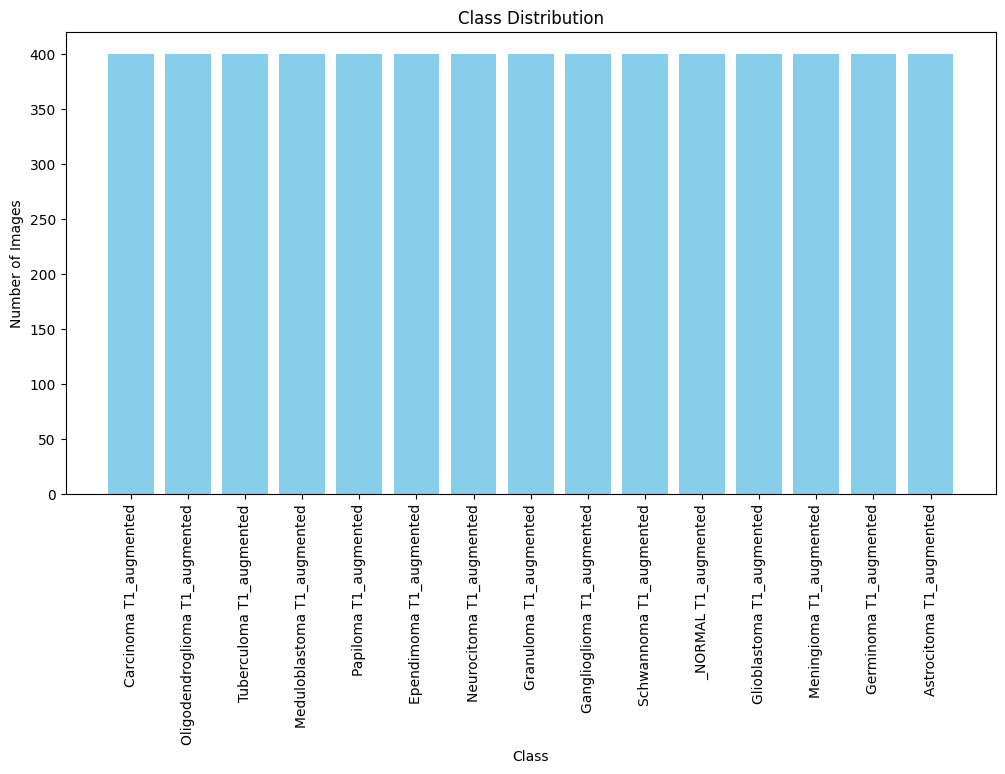

In [7]:
dataset_folder_path = '/content/drive/MyDrive/Brain_Tumor_Albumented_Balanced_Final2'
import os
class_counts = {}
for class_folder in os.listdir(dataset_folder_path):
    class_path = os.path.join(dataset_folder_path, class_folder)

    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_folder] = num_images

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")

import matplotlib.pyplot as plt

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

